In [1]:
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Clothing_Shoes_and_Jewelry_5.json.gz')

In [2]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014"


In [3]:
df.shape

(278677, 9)

In [4]:
print("Number of unique users:",len(df['reviewerID'].unique()))

Number of unique users: 39387


In [5]:
print("Number of unique products:",len(df['asin'].unique()))

Number of unique products: 23033


In [6]:
density=df.shape[0]/(len(df['reviewerID'].unique())*len(df['asin'].unique()))
print("density:",density*100,"%")

density: 0.03071833809100676 %


In [7]:
df['overall'].unique()

array([5., 4., 3., 1., 2.])

In [8]:
dataset=df.drop(['reviewerName','helpful','reviewText','summary','unixReviewTime','reviewTime'],axis=1)

In [9]:
from sklearn.model_selection import train_test_split
train_data,test_data=train_test_split(dataset,test_size=0.3,random_state=42)

In [10]:
print(train_data.shape)
print(test_data.shape)

(195073, 3)
(83604, 3)


In [11]:
customer_key={}
product_key={}
i=0
j=0
for cust_id in train_data['reviewerID'].unique():
    customer_key[cust_id]=i
    i+=1
for prod_id in train_data['asin'].unique():
    product_key[prod_id]=j
    j+=1

In [12]:
train_data=train_data.reset_index()
train_data.drop('index',inplace=True,axis=1)
train_data

,reviewerID,asin,overall
0,A39TYV0J07OWKK,B001MXGXKU,4.0
1,A29YBFFD18XO8G,B002BFXLJE,4.0
2,A34Z9I3XYZOFYO,B00E3GRC9E,2.0
3,A361E3RBTYPJE,B003JZCQGE,2.0
4,ACYANSO2REKG6,B000UPVCPW,5.0
...,...,...,...
195068,A3O8TYUVCU7ZDB,B0046HA9OK,3.0
195069,A3UJ9EZ71WHJ3T,B00CVQ16S6,5.0
195070,A620I80OLZO7I,B004LRO48M,5.0
195071,A2VPQDBJMZI7FY,B0055X1NDA,3.0


In [13]:
from tqdm import tqdm 
mat_dataset=[]
for i in tqdm(range(train_data.shape[0])):
    mat_dataset.append([customer_key[train_data['reviewerID'].iloc[i]],product_key[train_data['asin'].iloc[i]],train_data['overall'][i]])

100%|███████████████████████████████████████████████████████████████████████| 195073/195073 [00:13<00:00, 14869.96it/s]


In [14]:
cleaned_df=pd.DataFrame(mat_dataset,columns=['user','product','rating'])
cleaned_df

,user,product,rating
0,0,0,4.0
1,1,1,4.0
2,2,2,2.0
3,3,3,2.0
4,4,4,5.0
...,...,...,...
195068,13578,2900,3.0
195069,11920,18338,5.0
195070,11854,1974,5.0
195071,910,5350,3.0


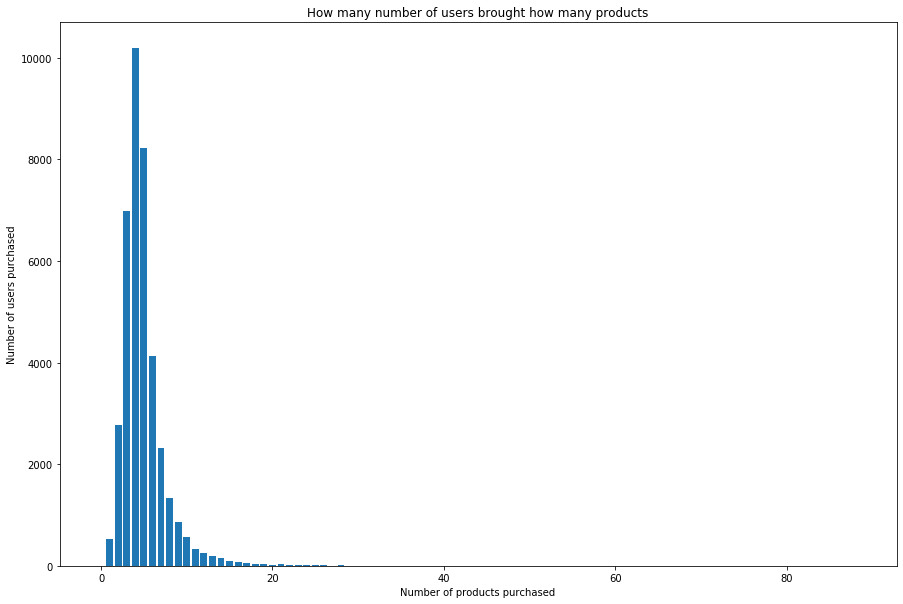

In [16]:
import matplotlib.pyplot as plt
import numpy as np
value,freq=np.unique(cleaned_df['user'],return_counts=True)
max_freq_value=max(freq)
freq_counts,bins=np.histogram(freq,bins=np.arange(max_freq_value+1))
fig=plt.figure(figsize=(15,10))
plt.bar(x=list(np.arange(max_freq_value)),height=list(freq_counts))
plt.xlabel("Number of products purchased")
plt.ylabel("Number of users purchased")
plt.title("How many number of users brought how many products")
plt.show()

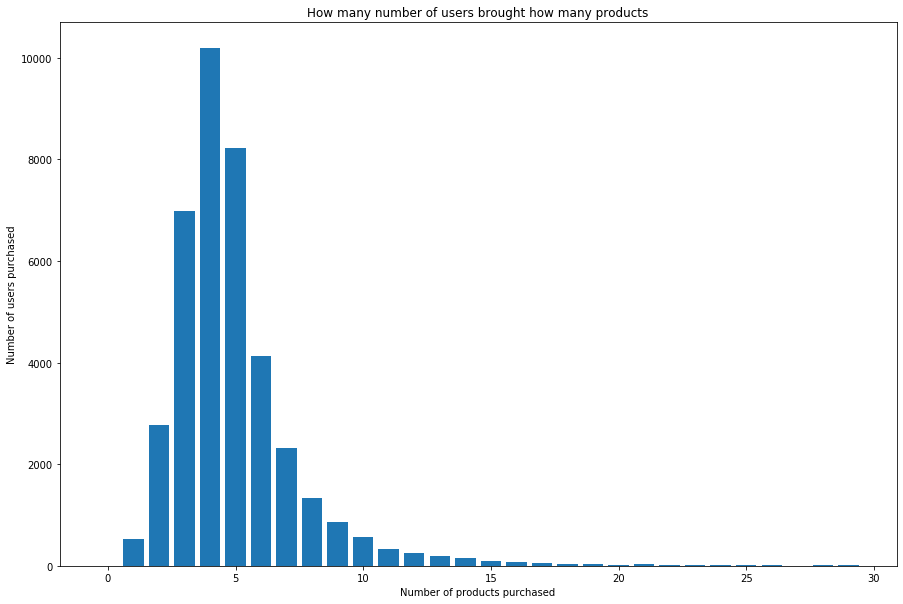

In [17]:
import matplotlib.pyplot as plt
import numpy as np
value,freq=np.unique(cleaned_df['user'],return_counts=True)
freq_counts,bins=np.histogram(freq,bins=np.arange(31))
fig=plt.figure(figsize=(15,10))
plt.bar(x=list(np.arange(30)),height=list(freq_counts))
plt.xlabel("Number of products purchased")
plt.ylabel("Number of users purchased")
plt.title("How many number of users brought how many products")
plt.show()

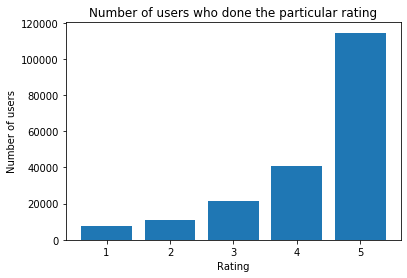

In [18]:
value,freq=np.unique(cleaned_df['rating'],return_counts=True)
plt.bar(np.arange(1,6),freq)
plt.title("Number of users who done the particular rating")
plt.xlabel("Rating")
plt.ylabel("Number of users")
plt.show()

In [19]:
from scipy.sparse import csr_matrix
adjacency_matrix=csr_matrix((cleaned_df['rating'],(cleaned_df['user'],cleaned_df['product'])))

In [20]:
test_data=test_data.reset_index()
test_data.drop('index',inplace=True,axis=1)
test_data

,reviewerID,asin,overall
0,A3VEG1Q7ENAL0F,B008AM4Q3C,5.0
1,A3LHZQMWBJBSLU,B002EQALPM,5.0
2,A3F91ZIAXKHIRW,B005GYGD7O,4.0
3,A7Y0ZTNQN1JD1,B0091KYB2I,5.0
4,A2H9Y30M7VRARG,B00453EQ7Q,1.0
...,...,...,...
83599,A3EPCK783K1GTD,B001OC5EYU,3.0
83600,A3GPUEQZFCYNPL,B000UG2FFW,2.0
83601,A156CPDDXGDTYG,B008R33TF0,5.0
83602,A16X8VK5ZAJTHD,B0023TPDPI,3.0


In [21]:
test_list=[]
for i in tqdm(range(test_data.shape[0])):
    if test_data['reviewerID'][i] in customer_key.keys():
            if test_data['asin'][i] in product_key.keys():
                test_list.append(
                    [customer_key[test_data['reviewerID'][i]],
                     product_key[test_data['asin'][i]],
                     test_data['overall'][i]])

100%|██████████████████████████████████████████████████████████████████████████| 83604/83604 [00:09<00:00, 8945.18it/s]


In [22]:
test_data=pd.DataFrame(test_list,columns=['user','product','rating'])

### Using SVD ###

In [23]:
def derivative_db(user_id,item_id,rating,U,V,mu,alpha):
    '''In this function, we will compute dL/db_i'''
    gradient=(alpha*b_i[user_id]*2)-(2*(rating-mu-b_i[user_id]-c_j[item_id]-np.matmul(U[user_id],V.T[item_id])))
    return gradient

def derivative_dc(user_id,item_id,rating,U,V,mu, alpha):
    '''In this function, we will compute dL/dc_j'''
    gradient=(alpha*c_j[item_id]*2)-(2*(rating-mu-b_i[user_id]-c_j[item_id]-np.matmul(U[user_id],V.T[item_id])))
    return gradient

In [24]:
from tqdm import tqdm 
import numpy as np

import time
start_time = time.time()

svd_time=time.time()
from sklearn.utils.extmath import randomized_svd
U, Sigma, VT = randomized_svd(adjacency_matrix, n_components=10,n_iter=5, random_state=None)
print("Time taken for SVD transformation is {} seconds".format(time.time()-svd_time))

overall_train_mse=[]
overall_test_mse=[]
epochs=10
learning_rate=0.01
alpha=0.1

U,Sigma,VT=randomized_svd(adjacency_matrix,n_components=5,n_iter=5)
b_i= np.zeros(adjacency_matrix.shape[0])
c_j= np.zeros(adjacency_matrix.shape[1])
it=cleaned_df['product']
us=cleaned_df['user']
mu=cleaned_df['rating'].mean()
indices=list(zip(us,it))

for epoch in range(epochs):
    epoch_start_time=time.time()
    L=0
    se=[]
    for user_id,item_id in indices:
        b_i[user_id]=b_i[user_id]-(learning_rate*derivative_db(user_id,item_id,adjacency_matrix[user_id,item_id],U,VT,mu,alpha))
        c_j[item_id]=c_j[item_id]-(learning_rate*derivative_dc(user_id,item_id,adjacency_matrix[user_id,item_id],U,VT,mu,alpha))
        y_pred=mu+b_i[user_id]+c_j[item_id]+np.matmul(U[user_id],VT.T[item_id])
        se.append((adjacency_matrix[user_id,item_id]-y_pred)**2)
    mse=np.mean(se)
    print("Train mean square error:",mse)
    print("Time taken for {0} epoch is {1}".format(epoch+1,time.time()-epoch_start_time))
    overall_train_mse.append(mse)
    
    y_overall_test_pred=[]
    for test_user in test_list:
        y_test_pred=mu+b_i[test_user[0]]+c_j[test_user[1]]+np.matmul(U[test_user[0]],VT.T[test_user[1]])
        y_overall_test_pred.append(y_test_pred)
    overall_mse=[]
    for i in range(len(test_list)):
        se=(test_list[i][2]-y_overall_test_pred[i])**2
        overall_mse.append(se)
    test_mse=np.array(overall_mse).mean()
    overall_test_mse.append(test_mse)
    print("Test mean square error:",test_mse)
    print('*'*50)
    if epoch>=2 and overall_test_mse[-2]-overall_test_mse[-1]<=0.001:
        print("No improvements in test error")
        print('*'*50)
        break
    
print("Overall training time:",(time.time() - start_time))

Time taken for SVD transformation is 1.1184415817260742 seconds
Train mean square error: 1.0903901137553595
Time taken for 1 epoch is 28.86245059967041
Test mean square error: 1.1561962302837707
**************************************************
Train mean square error: 0.9833924047686907
Time taken for 2 epoch is 29.65298581123352
Test mean square error: 1.1265009409947244
**************************************************
Train mean square error: 0.9122180867138187
Time taken for 3 epoch is 27.60319709777832
Test mean square error: 1.1102837958749787
**************************************************
Train mean square error: 0.8604361526295877
Time taken for 4 epoch is 26.57176423072815
Test mean square error: 1.1015052704219275
**************************************************
Train mean square error: 0.8210939126526058
Time taken for 5 epoch is 29.446094274520874
Test mean square error: 1.0973290623024066
**************************************************
Train mean square error: 

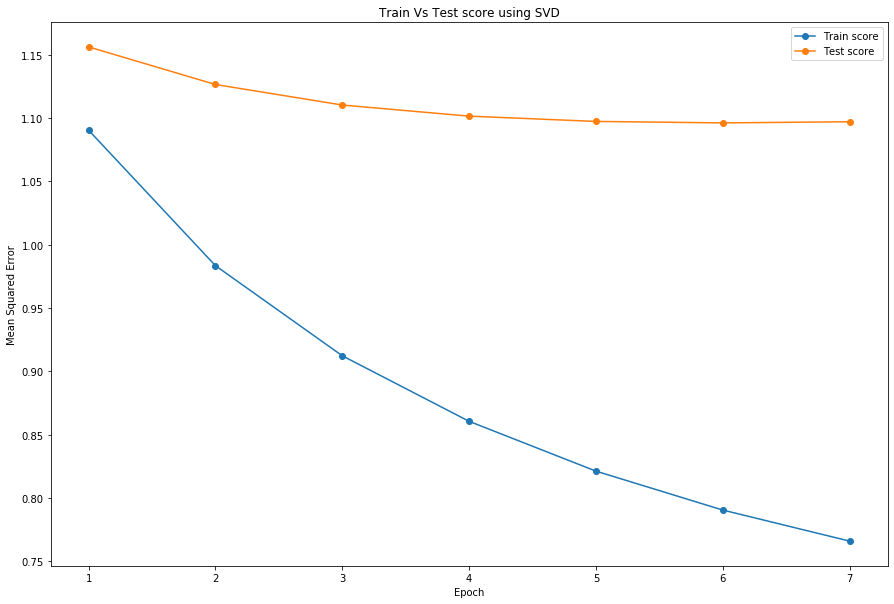

In [25]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(15,10))
plt.plot(np.arange(1,len(overall_train_mse)+1),overall_train_mse,label='Train score',marker='o')
plt.plot(np.arange(1,len(overall_test_mse)+1),overall_test_mse,label='Test score',marker='o')
plt.title("Train Vs Test score using SVD")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

In [26]:
print("Some sample predictions done using SVD compared with true values")
for i in range(10):
    print("True rating:",test_list[i][2],"Predicted rating",y_overall_test_pred[i])

Some sample predictions done using SVD compared with true values
True rating: 5.0 Predicted rating 3.503156625369295
True rating: 5.0 Predicted rating 4.984007827488396
True rating: 4.0 Predicted rating 3.9953076433218526
True rating: 5.0 Predicted rating 4.127234360418105
True rating: 1.0 Predicted rating 3.450916443279411
True rating: 5.0 Predicted rating 4.34001400908689
True rating: 2.0 Predicted rating 4.201996544969539
True rating: 5.0 Predicted rating 4.480146377750839
True rating: 5.0 Predicted rating 4.772812205427201
True rating: 5.0 Predicted rating 3.7974435074524626


### Using SGD###

In [27]:
def derivative_db(user_id,item_id,rating,U,V,mu,alpha):
    '''In this function, we will compute dL/db_i'''
    gradient=(alpha*b_i_sgd[user_id]*2)-(2*(rating-mu-b_i_sgd[user_id]-c_j_sgd[item_id]-np.matmul(U[user_id],V.T[item_id])))
    return gradient

def derivative_dc(user_id,item_id,rating,U,V,mu, alpha):
    '''In this function, we will compute dL/dc_j'''
    gradient=(alpha*c_j_sgd[item_id]*2)-(2*(rating-mu-b_i_sgd[user_id]-c_j_sgd[item_id]-np.matmul(U[user_id],V.T[item_id])))
    return gradient

def gradient_du(user_id,item_id,rating,U,V,mu, alpha):
  gradient=(alpha*2*np.matmul(U[user_id],U[user_id]))+(2*(rating-mu-b_i_sgd[user_id]-c_j_sgd[item_id]-np.matmul(U[user_id],V.T[item_id]))*V.T[item_id])
  return gradient

def gradient_dv(user_id,item_id,rating,U,V,mu, alpha):
  gradient=(alpha*2*np.matmul(V.T[item_id],V.T[item_id]))+(2*(rating-mu-b_i_sgd[user_id]-c_j_sgd[item_id]-np.matmul(U[user_id],V.T[item_id]))*U[user_id])
  return gradient                                            

In [28]:
from tqdm import tqdm 

import time
start_time = time.time()

b_i_sgd=np.zeros(adjacency_matrix.shape[0])
c_j_sgd=np.zeros(adjacency_matrix.shape[1])

overall_train_mse=[]
overall_test_mse=[]
epochs=10
learning_rate=0.01
alpha=0.1

m_u_sgd=train_data['overall'].mean()
U_SGD=np.zeros((adjacency_matrix.shape[0],10))
VT_SGD=np.zeros((10,adjacency_matrix.shape[1]))

pr=cleaned_df['product']
us=cleaned_df['user']
indices=list(zip(us,pr))

for epoch in range(epochs):
    epoch_start_time=time.time()
    L=0
    se=[]
    for user_id,item_id in indices:
        b_i_sgd[user_id]=b_i_sgd[user_id]-(learning_rate*derivative_db(user_id,item_id,adjacency_matrix[user_id,item_id],U_SGD,VT_SGD,m_u_sgd,alpha))
        c_j_sgd[item_id]=c_j_sgd[item_id]-(learning_rate*derivative_dc(user_id,item_id,adjacency_matrix[user_id,item_id],U_SGD,VT_SGD,m_u_sgd,alpha))
        U_SGD[user_id]=U_SGD[user_id]-(learning_rate*gradient_du(user_id,item_id,adjacency_matrix[user_id,item_id],U_SGD,VT_SGD,m_u_sgd,alpha))
        VT_SGD.T[item_id]=VT_SGD.T[item_id]-(learning_rate*gradient_dv(user_id,item_id,adjacency_matrix[user_id,item_id],U_SGD,VT_SGD,m_u_sgd,alpha))
        y_pred=m_u_sgd+b_i_sgd[user_id]+c_j_sgd[item_id]+np.matmul(U_SGD[user_id],VT_SGD.T[item_id])
        se.append((adjacency_matrix[user_id,item_id]-y_pred)**2)
    mse=np.mean(se)
    print("Train mean square error:",mse)
    print("Time taken for {0} epoch is {1}".format(epoch+1,time.time()-epoch_start_time))
    overall_train_mse.append(mse)
    
    #Testing
    y_overall_test_pred=[]
    for test_user in test_list:
        y_test_pred=m_u_sgd+b_i_sgd[test_user[0]]+c_j_sgd[test_user[1]]+np.matmul(U_SGD[test_user[0]],VT_SGD.T[test_user[1]])
        y_overall_test_pred.append(y_test_pred)
    test_mse=[]
    for i in range(len(test_list)):
        se=(test_list[i][2]-y_overall_test_pred[i])**2
        test_mse.append(se)
    test_mse=np.array(test_mse).mean()
    overall_test_mse.append(test_mse)
    print("Test mean square error:",test_mse)
    print('*'*50)
    if epoch>=2 and overall_test_mse[-2]-overall_test_mse[-1]<=0.001:
        print("No improvements in test error")
        print('*'*50)
        break
    
print("Overall training time:",(time.time() - start_time))

Train mean square error: 1.0905551614353812
Time taken for 1 epoch is 60.493308305740356
Test mean square error: 1.156228077424346
**************************************************
Train mean square error: 0.983541618977723
Time taken for 2 epoch is 61.226919174194336
Test mean square error: 1.1265311354853462
**************************************************
Train mean square error: 0.912357093194993
Time taken for 3 epoch is 60.8610942363739
Test mean square error: 1.1103119990268686
**************************************************
Train mean square error: 0.8605673093237912
Time taken for 4 epoch is 63.77445912361145
Test mean square error: 1.1015323570046456
**************************************************
Train mean square error: 0.8212189381539912
Time taken for 5 epoch is 74.2374496459961
Test mean square error: 1.0973556368380206
**************************************************
Train mean square error: 0.7904669709900349
Time taken for 6 epoch is 73.74870419502258
Test 

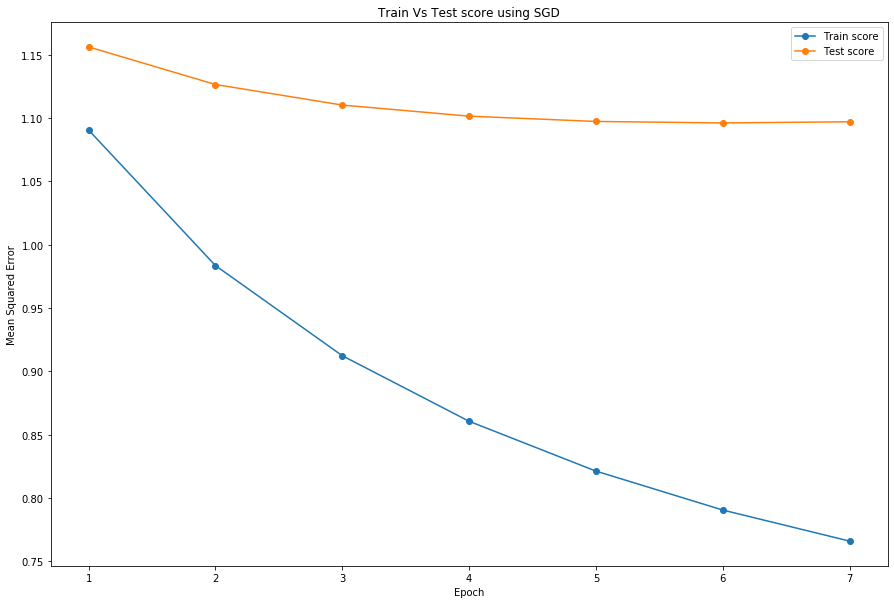

In [29]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(15,10))
plt.plot(np.arange(1,len(overall_train_mse)+1),overall_train_mse,label='Train score',marker='o')
plt.plot(np.arange(1,len(overall_test_mse)+1),overall_test_mse,label='Test score',marker='o')
plt.title("Train Vs Test score using SGD")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

In [30]:
print("Some sample predictions made using SGD compared with true values")
for i in range(10):
    print("True rating:",test_list[i][2],"Predicted rating",y_overall_test_pred[i])

Some sample predictions made using SGD compared with true values
True rating: 5.0 Predicted rating 3.5031233872914704
True rating: 5.0 Predicted rating 4.984007757521433
True rating: 4.0 Predicted rating 4.045884560840372
True rating: 5.0 Predicted rating 4.127363879953404
True rating: 1.0 Predicted rating 3.450917276351965
True rating: 5.0 Predicted rating 4.340013821890079
True rating: 2.0 Predicted rating 4.2019073732610215
True rating: 5.0 Predicted rating 4.480229602530589
True rating: 5.0 Predicted rating 4.772830589353966
True rating: 5.0 Predicted rating 3.797436619814654
